In [16]:
# Month of the prediction model (no data will be used past this month, as we are predicting production at a point in time)
month = 8

In [17]:
import pandas as pd

def load_province_breakouts(filename):

    # Province crop data - manually brought in from https://ipad.fas.usda.gov/countrysummary/default.aspx?id=SG
    province_splits = pd.read_csv(filename)

    # Remove all columns that have Labeled in the title
    province_splits = province_splits.loc[:, ~province_splits.columns.str.contains('Labeled')]

    # Remove Total_Pct and Missing_Pct and Missing_Provinces columns
    province_splits = province_splits.drop(columns=["Total_Pct", "Missing_Pct", "Missing_Provinces"])

    return province_splits

province_splits = load_province_breakouts("province_production_breakouts.csv")

province_splits

,Crop,Dakar,Diourbel,Fatick,Kaffrine,Kaolack,Kedougou,Kolda,Louga,Matam,Saint louis,Sedhiou,Tambacounda,Thies,Ziguinchor
0,Corn,0.032000,0.032000,0.100,0.032,0.160,0.032000,0.24,0.032,0.032000,0.032000,0.210000,0.130,0.032,0.032000
1,Cotton,0.000000,0.000000,0.000,0.050,0.010,0.060000,0.62,0.000,0.000000,0.000000,0.010000,0.250,0.000,0.000000
2,Millet,0.001111,0.070000,0.180,0.230,0.160,0.001111,0.08,0.050,0.001111,0.001111,0.080000,0.060,0.080,0.001111
3,Peanut,0.015714,0.015714,0.130,0.220,0.150,0.015714,0.17,0.080,0.015714,0.015714,0.015714,0.070,0.070,0.015714
4,Rice,0.025000,0.025000,0.025,0.025,0.025,0.025000,0.27,0.025,0.025000,0.220000,0.250000,0.025,0.025,0.160000
5,Sorghum,0.036000,0.036000,0.036,0.260,0.110,0.036000,0.15,0.036,0.036000,0.036000,0.130000,0.170,0.036,0.036000


In [18]:
def load_production_data(filename):

    # Bring in production dataset, from FAOSTAT
    production = pd.read_csv(filename)

    production = production[production['Element'] == 'Production']
    production = production[production['Value'] != 0]

    items_prod = [
            "Groundnuts, excluding shelled",
            "Maize (corn)",
            "Millet",
            "Rice",
            "Sorghum"]

    items = ["Peanut", "Corn", "Millet", "Rice", "Sorghum"]

    # Change names of items in production data to match those in items list
    production['Item'] = production['Item'].replace({
        "Groundnuts, excluding shelled": "Peanut",
        "Maize (corn)": "Corn",
        "Millet": "Millet",
        "Rice": "Rice",
        "Sorghum": "Sorghum"
    })

    # Only keep those items
    production = production[production['Item'].isin(items)]

    # Only keep Item, Value, Year columns
    production = production[['Item', 'Value', 'Year']]

    # Values of 2023 for each crop (manually pulled from website)
    production_2023 = pd.DataFrame({
        "Item": items,
        "Value": [1728000, 929000, 1353000, 1521000, 445000],
        "Year": [2023, 2023, 2023, 2023, 2023]
    })

    # Append 2023 data to production (append is no longer used in pandas, so remember to use the new function)
    production = pd.concat([production,production_2023], axis=0)

    return production

production = load_production_data("FAOSTAT_data_en_8-7-2024.csv")

# Calculate number of rows for each item in total not by column
production['Item'].value_counts()

Item
Peanut     63
Corn       63
Millet     63
Rice       63
Sorghum    63
Name: count, dtype: int64

In [19]:
def load_vhi_data(filename, month):

    # Load in vhi data
    vhi = pd.read_csv(filename)

    # Get the average value of Data column, for July with Year as rows and Province as columns
    vhi_filtered = vhi[vhi['Month'] == month-1]
    vhi_filtered = vhi_filtered.pivot_table(index='Year', columns='Province', values='Data', aggfunc='mean')

    # Calculate the weighted average VHI for each crop
    for crop in province_splits['Crop']:
        # Extract the percentage values for the current crop (ignoring the Crop column)
        crop_percentages = province_splits.set_index('Crop').loc[crop]
        
        # Perform the sumproduct: multiply VHI values by the crop percentages and sum across provinces
        vhi_filtered[f'{crop}_Weighted_VHI'] = vhi_filtered.mul(crop_percentages).sum(axis=1)

    
    return vhi_filtered

vhi_filtered = load_vhi_data("vhi_adm1_dekad_data.csv", month)

# View updated data
vhi_filtered.head()

Province,Dakar,Diourbel,Fatick,Kaffrine,Kaolack,Kedougou,Kolda,Louga,Matam,Saint louis,Sedhiou,Tambacounda,Thies,Ziguinchor,Corn_Weighted_VHI,Cotton_Weighted_VHI,Millet_Weighted_VHI,Peanut_Weighted_VHI,Rice_Weighted_VHI,Sorghum_Weighted_VHI
Year,,,,,,,,,,,,,,,,,,,,
1984,0.322000,0.614667,0.567333,0.620333,0.637333,0.381667,0.501000,0.478333,0.385667,0.378667,0.567000,0.483667,0.494333,0.489000,0.594163,0.497497,0.569894,0.547045,0.563200,0.610497
1985,0.224333,0.404667,0.381000,0.341000,0.382667,0.437333,0.406000,0.452667,0.325000,0.308667,0.373000,0.348667,0.289333,0.380333,0.421650,0.389733,0.367445,0.370396,0.421297,0.414737
1986,0.154000,0.059333,0.130667,0.137667,0.096000,0.411333,0.321667,0.083333,0.038667,0.161333,0.228667,0.236333,0.107667,0.254000,0.229405,0.293327,0.146816,0.167647,0.256525,0.214919
1987,0.178667,0.181667,0.266333,0.506333,0.372667,0.350000,0.549667,0.263333,0.313333,0.225000,0.529000,0.401333,0.183000,0.450000,0.466286,0.496460,0.376606,0.392336,0.477577,0.478895
1988,0.319000,0.337333,0.338000,0.431000,0.417333,0.492333,0.571667,0.384000,0.474000,0.416000,0.480000,0.537000,0.339000,0.404333,0.523487,0.548747,0.415370,0.436516,0.532288,0.523551


In [20]:
def load_rainfall_data(filename, month):

    # Load in rainfall data
    rainfall = pd.read_csv(filename)

    # Convert the 'Date' column to datetime format
    rainfall['Date'] = pd.to_datetime(rainfall['Date'], format='%Y-%m-%d')

    # Filter out rows where the month is August (8) or higher
    rainfall_filtered = rainfall[rainfall['Date'].dt.month <= 7]

    # Group by Year and Province, then sum the 'Data' column
    rainfall_grouped = rainfall_filtered.groupby(['Year', 'Province'])['Data'].sum().reset_index()

    # Pivot the table to have years as rows and provinces as columns
    rainfall_pivot = rainfall_grouped.pivot(index='Year', columns='Province', values='Data')

    # Calculate the weighted average rainfall for each crop
    for crop in province_splits['Crop']:
        # Extract the percentage values for the current crop (ignoring the Crop column)
        crop_percentages = province_splits.set_index('Crop').loc[crop]
        
        # Perform the sumproduct: multiply VHI values by the crop percentages and sum across provinces
        rainfall_pivot[f'{crop}_Weighted_Rainfall'] = rainfall_pivot.mul(crop_percentages).sum(axis=1)

    return rainfall_pivot

rainfall_pivot = load_rainfall_data("rain_adm1_data.csv", month)

# View updated data
rainfall_pivot.tail()

Province,Dakar,Diourbel,Fatick,Kaffrine,Kaolack,Kedougou,Kolda,Louga,Matam,Saint louis,Sedhiou,Tambacounda,Thies,Ziguinchor,Corn_Weighted_Rainfall,Cotton_Weighted_Rainfall,Millet_Weighted_Rainfall,Peanut_Weighted_Rainfall,Rice_Weighted_Rainfall,Sorghum_Weighted_Rainfall
Year,,,,,,,,,,,,,,,,,,,,
2020,251.537,200.120,281.237,263.514,308.791,609.945,395.749,179.091,214.231,117.752,524.200,312.050,214.184,558.237,406.634072,381.47919,295.000365,298.202448,423.993090,377.585524
2021,111.317,213.947,192.499,341.560,327.854,686.113,385.281,143.155,206.965,106.635,393.273,323.653,146.847,329.645,361.994088,385.24352,282.851310,291.412548,345.894770,365.744618
2022,267.542,237.950,222.557,305.124,231.658,710.692,387.840,143.657,158.623,178.726,541.975,357.842,203.556,773.699,408.082998,395.55535,285.605034,292.619149,474.302135,398.572582
2023,84.889,141.247,169.778,184.895,187.370,488.881,301.353,123.207,180.216,134.441,292.405,248.395,123.378,292.896,269.107720,292.31297,192.699891,203.342399,279.213340,256.727738
2024,71.441,114.043,175.167,171.520,202.497,404.991,264.203,90.903,148.701,83.387,327.911,196.450,81.128,411.035,258.193518,251.09790,182.797650,187.035869,278.844325,239.433906


### Test for one prediction in one year to figure out mechanism

Training data from: 2002 to 2022
Predicting for year: 2023
                        Production_Diff  Weighted_VHI_Diff  \
Production_Diff                1.000000           0.406562   
Weighted_VHI_Diff              0.406562           1.000000   
Weighted_Rainfall_Diff         0.422333           0.823359   

                        Weighted_Rainfall_Diff  
Production_Diff                       0.422333  
Weighted_VHI_Diff                     0.823359  
Weighted_Rainfall_Diff                1.000000  


<Axes: xlabel='Year'>

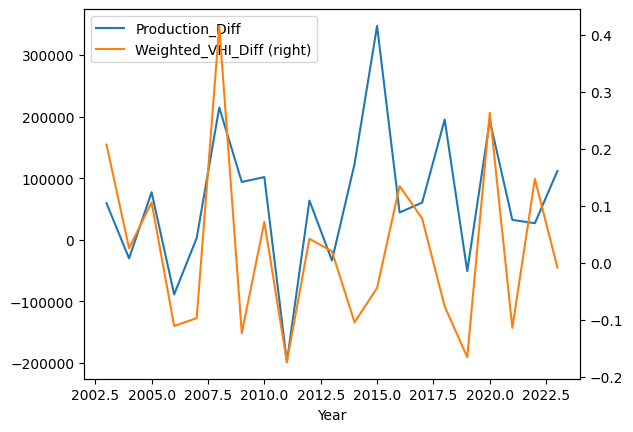

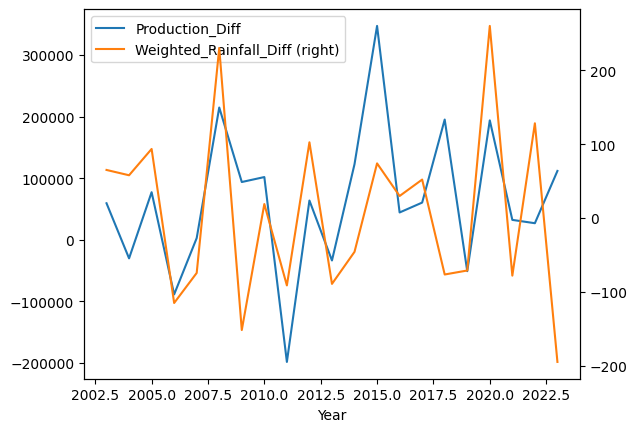

In [31]:
# Select a crop
crop = "Rice"
year = 2023
n_years = 20

train_start = year - n_years - 1
train_end = train_start + 20

print(f"Training data from: {train_start} to {train_end}")
print(f"Predicting for year: {year}")

# Create our df by getting year and production amount from train_start to year
df = production[production['Year'].between(train_start, year)]

# Filter for the selected crop
df = df[df['Item'] == crop]
df = df[['Year', 'Value']]

# Change column name of Value to Production
df = df.rename(columns={'Value': 'Production'})

# Bring in the VHI data for this crop, so it will be the column name + "_Weighted_VHI"
df = df.merge(vhi_filtered[[f'{crop}_Weighted_VHI']], left_on='Year', right_on='Year')

# Then remove the crop name and underscore at the start of the column name
df = df.rename(columns={f'{crop}_Weighted_VHI': 'Weighted_VHI'})

# Bring in the Rainfall data for this crop, so it will be the column name + "_Weighted_VHI"
df = df.merge(rainfall_pivot[[f'{crop}_Weighted_Rainfall']], left_on='Year', right_on='Year')

# Then remove the crop name and underscore at the start of the column name
df = df.rename(columns={f'{crop}_Weighted_Rainfall': 'Weighted_Rainfall'})

# Now do differencing for both the Production and Weighted_VHI columns
df['Production_Diff'] = df['Production'].diff()
df['Weighted_VHI_Diff'] = df['Weighted_VHI'].diff()
df['Weighted_Rainfall_Diff'] = df['Weighted_Rainfall'].diff()

# Now look at correlation between the two columns
print(df[['Production_Diff', 'Weighted_VHI_Diff', 'Weighted_Rainfall_Diff']].corr())

# Now plot the two columns over time on different axes
df.plot(x='Year', y=['Production_Diff', 'Weighted_VHI_Diff'], secondary_y=['Weighted_VHI_Diff'])

df.plot(x='Year', y=['Production_Diff', 'Weighted_Rainfall_Diff'], secondary_y=['Weighted_Rainfall_Diff'])

In [40]:
# Now train a model to predict the Production_Diff from the Weighted_VHI_Diff
from sklearn.linear_model import LinearRegression

# Create a linear regression model
model = LinearRegression()

# Create df_train, removing the first row and last row in df
df_train = df.iloc[1:-1]

# Fit the model to the data before the last row (the test year), using Weighted_VHI_Diff and Weighted_Rainfall_Diff
model.fit(df_train[['Weighted_VHI_Diff', 'Weighted_Rainfall_Diff']], df_train['Production_Diff'])

# Now predict the difference in production for the test year
prediction = model.predict(df[['Weighted_VHI_Diff', 'Weighted_Rainfall_Diff']].iloc[-1:])

# Now calculate the production for the test year
production_prediction = df['Production'].iloc[-2] + prediction

# Now compare the prediction to the actual value
print(f"Predicted production: {production_prediction[0]}")
print(f"Actual production: {df['Production'].iloc[-1]}")

# Calculate and print the total error and percentage error
error = production_prediction - df['Production'].iloc[-1]
percentage_error = error / df['Production'].iloc[-1] * 100

print(f"Error: {error[0]}")
print(f"Percentage error: {percentage_error[0]}%")

Predicted production: 1345048.3834102652
Actual production: 1521000.0
Error: -175951.6165897348
Percentage error: -11.568153621941802%


In [39]:
df['Production'].iloc[-2]

1409120.0

In [36]:
production_prediction

array([1456928.38341027])

In [35]:
prediction

array([-64071.61658973])

In [33]:
df_train.to_csv("traindata.csv")

### Function to train a model and get test results for one year and one crop

In [41]:
from sklearn.linear_model import LinearRegression

def predict_crop_for_one_year(prediction_year, crop):
    # Select a crop
    crop = crop
    year = prediction_year

    train_start = year - n_years - 1
    train_end = train_start + 20

    print(f"Training data from: {train_start} to {train_end}")
    print(f"Predicting for year: {year}")

    # Create our df by getting year and production amount from train_start to year
    df = production[production['Year'].between(train_start, year)]

    # Filter for the selected crop
    df = df[df['Item'] == crop]
    df = df[['Year', 'Value']]

    # Change column name of Value to Production
    df = df.rename(columns={'Value': 'Production'})

    # Bring in the VHI data for this crop, so it will be the column name + "_Weighted_VHI"
    df = df.merge(vhi_filtered[[f'{crop}_Weighted_VHI']], left_on='Year', right_on='Year')

    # Then remove the crop name and underscore at the start of the column name
    df = df.rename(columns={f'{crop}_Weighted_VHI': 'Weighted_VHI'})

    # Bring in the Rainfall data for this crop, so it will be the column name + "_Weighted_VHI"
    df = df.merge(rainfall_pivot[[f'{crop}_Weighted_Rainfall']], left_on='Year', right_on='Year')

    # Then remove the crop name and underscore at the start of the column name
    df = df.rename(columns={f'{crop}_Weighted_Rainfall': 'Weighted_Rainfall'})

    # Now do differencing for both the Production and Weighted_VHI columns
    df['Production_Diff'] = df['Production'].diff()
    df['Weighted_VHI_Diff'] = df['Weighted_VHI'].diff()
    df['Weighted_Rainfall_Diff'] = df['Weighted_Rainfall'].diff()

    # Now look at correlation between the two columns
    # print(df[['Production_Diff', 'Weighted_VHI_Diff']].corr())

    # Now plot the two columns over time on different axes
    # df.plot(x='Year', y=['Production_Diff', 'Weighted_VHI_Diff'], secondary_y=['Weighted_VHI_Diff'])

    # Create df_train, removing the first row and last row in df
    df_train = df.iloc[1:-1]

    # Fit the model to the data before the last row (the test year), using Weighted_VHI_Diff and Weighted_Rainfall_Diff
    model.fit(df_train[['Weighted_VHI_Diff', 'Weighted_Rainfall_Diff']], df_train['Production_Diff'])

    # Now predict the difference in production for the test year
    prediction = model.predict(df[['Weighted_VHI_Diff', 'Weighted_Rainfall_Diff']].iloc[-1:])

    # Now calculate the production for the test year
    production_prediction = df['Production'].iloc[-2] + prediction
    actual_production = df['Production'].iloc[-1]

    # Now compare the prediction to the actual value
    # print(f"Predicted production: {production_prediction[0]}")
    # print(f"Actual production: {df['Production'].iloc[-1]}")

    # Calculate and print the total error and percentage error
    error = production_prediction - df['Production'].iloc[-1]
    percentage_error = error / df['Production'].iloc[-1] * 100

    # print(f"Error: {error[0]}")
    # print(f"Percentage error: {percentage_error[0]}%")

    return production_prediction[0], actual_production, error[0], percentage_error[0]

### Train and test the model across all years and all crops, saving results for each iteration

In [42]:
# For each crop, and for each year from 2017 to 2022, run predict_crop_for_one_year and save results in a table
results = []

items = ["Peanut", "Corn", "Millet", "Rice", "Sorghum"]

for crop in items:
    print(crop)
    for year in range(2017, 2024):
        results.append([crop, year, *predict_crop_for_one_year(year, crop)])
        print("-----------------------")

results_df = pd.DataFrame(results, columns=['Crop', 'Year', 'Predicted Production', 'Actual Production', 'Error', 'Percentage Error'])
results_df

Peanut
Training data from: 1996 to 2016
Predicting for year: 2017
-----------------------
Training data from: 1997 to 2017
Predicting for year: 2018
-----------------------
Training data from: 1998 to 2018
Predicting for year: 2019
-----------------------
Training data from: 1999 to 2019
Predicting for year: 2020
-----------------------
Training data from: 2000 to 2020
Predicting for year: 2021
-----------------------
Training data from: 2001 to 2021
Predicting for year: 2022
-----------------------
Training data from: 2002 to 2022
Predicting for year: 2023
-----------------------
Corn
Training data from: 1996 to 2016
Predicting for year: 2017
-----------------------
Training data from: 1997 to 2017
Predicting for year: 2018
-----------------------
Training data from: 1998 to 2018
Predicting for year: 2019
-----------------------
Training data from: 1999 to 2019
Predicting for year: 2020
-----------------------
Training data from: 2000 to 2020
Predicting for year: 2021
----------------

,Crop,Year,Predicted Production,Actual Production,Error,Percentage Error
0,Peanut,2017,9.007515e+05,1405223.00,-504471.498209,-35.899747
1,Peanut,2018,1.138477e+06,1500588.37,-362111.208188,-24.131282
2,Peanut,2019,1.417630e+06,1421288.11,-3657.853563,-0.257362
3,Peanut,2020,1.770286e+06,1797486.11,-27200.503105,-1.513252
4,Peanut,2021,1.726442e+06,1677803.56,48638.567991,2.898943
5,Peanut,2022,1.881474e+06,1501498.00,379975.672499,25.306439
6,Peanut,2023,1.366229e+06,1728000.00,-361770.699587,-20.935804
7,Corn,2017,4.948776e+05,410364.00,84513.570119,20.594782
8,Corn,2018,3.127446e+05,485672.51,-172927.920618,-35.605870
9,Corn,2019,4.537252e+05,530704.97,-76979.809548,-14.505199


C:\Users\mikej\AppData\Local\Temp\ipykernel_776\404306083.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, mean_absolute_percentage_error[i], f'{mean_absolute_percentage_error[i]:.2f}', ha = 'center')


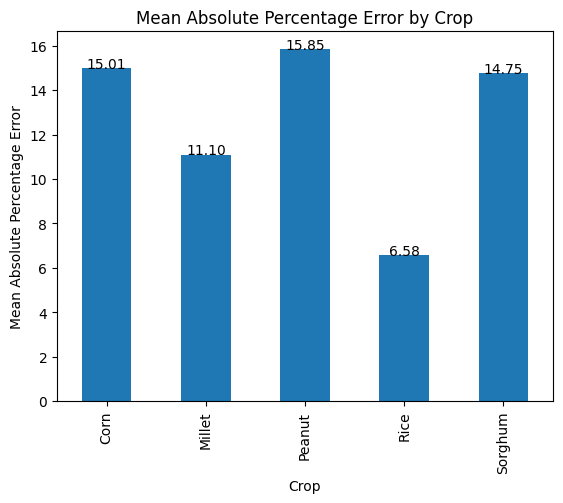

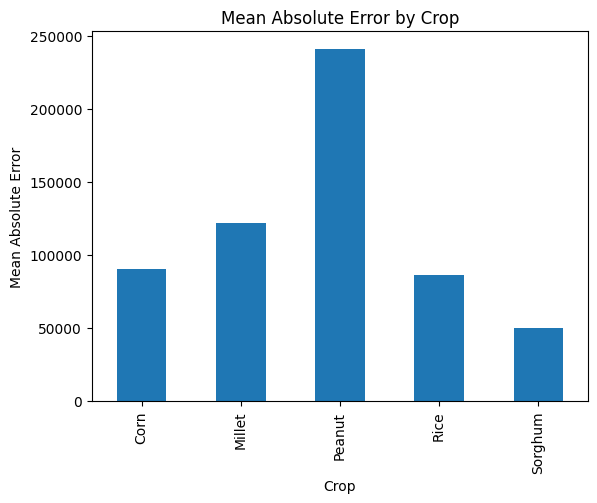

In [43]:
# Summarize mean absolute percent error and mean absolute error by crop across years in a two charts (one for each metric)
import matplotlib.pyplot as plt

results_df['Absolute Percentage Error'] = results_df['Percentage Error'].abs()
results_df['Absolute Error'] = results_df['Error'].abs()

mean_absolute_percentage_error = results_df.groupby('Crop')['Absolute Percentage Error'].mean()
mean_absolute_error = results_df.groupby('Crop')['Absolute Error'].mean()

mean_absolute_percentage_error.plot(kind='bar')
plt.ylabel('Mean Absolute Percentage Error')
plt.title('Mean Absolute Percentage Error by Crop')
# Include labels
for i in range(len(mean_absolute_percentage_error)):
    plt.text(i, mean_absolute_percentage_error[i], f'{mean_absolute_percentage_error[i]:.2f}', ha = 'center')
plt.show()

mean_absolute_error.plot(kind='bar')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error by Crop')
plt.show()

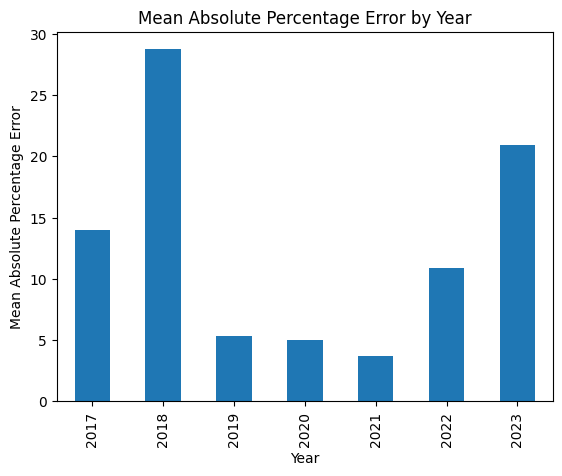

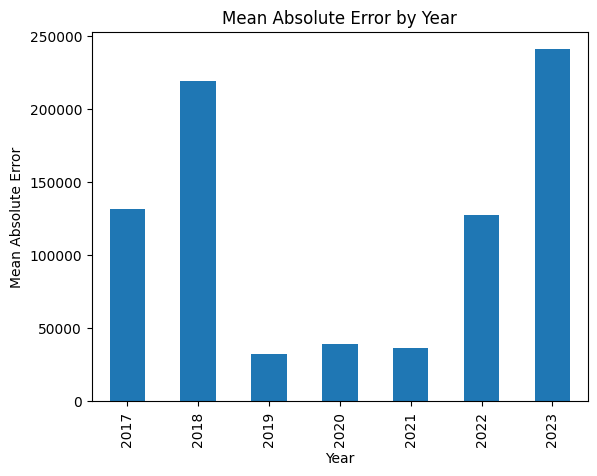

In [44]:
# Summarize the MAPE and MAE by year as well in two charts
mean_absolute_percentage_error_by_year = results_df.groupby('Year')['Absolute Percentage Error'].mean()
mean_absolute_error_by_year = results_df.groupby('Year')['Absolute Error'].mean()
mean_absolute_percentage_error_by_year.plot(kind='bar')
plt.ylabel('Mean Absolute Percentage Error')
plt.title('Mean Absolute Percentage Error by Year')
plt.show()

mean_absolute_error_by_year.plot(kind='bar')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error by Year')
plt.show()

In [45]:
# Manually collected data on predictions for 2022 to compare to
peanut = 1700000
millet = 1000000
rice = 932000 / 0.68 # Approximating rough production from milled production
corn = 500000
sorghum = 270000

# Compare accuracy of our 2022 predictions, the manually collected 2022 predictions, and the 2022 actuals
results_2022 = results_df.loc[results_df['Year'] == 2022].copy()  # Make a copy to avoid the warning

results_2022.loc[:, 'Manually Collected Prediction'] = [peanut, corn, millet, rice, sorghum]

results_2022.loc[:, 'Manually Collected Error'] = results_2022['Manually Collected Prediction'] - results_2022['Actual Production']

results_2022.loc[:, 'Manually Collected Percentage Error'] = results_2022['Manually Collected Error'] / results_2022['Actual Production'] * 100

# Calculate absolute manually collected percentage error
results_2022.loc[:, 'Absolute Manually Collected Percentage Error'] = results_2022['Manually Collected Percentage Error'].abs()

print(f"Their error rate: {results_2022['Absolute Manually Collected Percentage Error'].mean()}")
print(f"Our error rate: {results_2022['Absolute Percentage Error'].mean()}")

results_2022

Their error rate: 17.396253866223148
Our error rate: 10.90663682160253


,Crop,Year,Predicted Production,Actual Production,Error,Percentage Error,Absolute Percentage Error,Absolute Error,Manually Collected Prediction,Manually Collected Error,Manually Collected Percentage Error,Absolute Manually Collected Percentage Error
5,Peanut,2022,1.881474e+06,1501498.0,379975.672499,25.306439,25.306439,379975.672499,1.700000e+06,198502.000000,13.220264,13.220264
12,Corn,2022,8.527546e+05,787750.0,65004.567922,8.251929,8.251929,65004.567922,5.000000e+05,-287750.000000,-36.528086,36.528086
19,Millet,2022,1.154024e+06,1097033.0,56991.233818,5.195034,5.195034,56991.233818,1.000000e+06,-97033.000000,-8.845039,8.845039
26,Rice,2022,1.512339e+06,1409120.0,103219.197468,7.325082,7.325082,103219.197468,1.370588e+06,-38531.764706,-2.734456,2.734456
33,Sorghum,2022,3.938684e+05,363164.0,30704.429749,8.454701,8.454701,30704.429749,2.700000e+05,-93164.000000,-25.653424,25.653424


In [46]:
# Manually collected data on predictions for 2023 to compare to
peanut = 1715000
millet = 1000000
rice = 952000 / 0.68
corn = 650000
sorghum = 330000

# Compare accuracy of our 2022 predictions, the manually collected 2022 predictions, and the 2022 actuals
results_2023 = results_df.loc[results_df['Year'] == 2023].copy()  # Make a copy to avoid the warning

results_2023.loc[:, 'Manually Collected Prediction'] = [peanut, corn, millet, rice, sorghum]

results_2023.loc[:, 'Manually Collected Error'] = results_2023['Manually Collected Prediction'] - results_2023['Actual Production']

results_2023.loc[:, 'Manually Collected Percentage Error'] = results_2023['Manually Collected Error'] / results_2023['Actual Production'] * 100

# Calculate absolute manually collected percentage error
results_2023.loc[:, 'Absolute Manually Collected Percentage Error'] = results_2023['Manually Collected Percentage Error'].abs()

print(f"Their error rate: {results_2023['Absolute Manually Collected Percentage Error'].mean()}")
print(f"Our error rate: {results_2023['Absolute Percentage Error'].mean()}")

results_2023

Their error rate: 18.134553359051704
Our error rate: 20.901217935582117


,Crop,Year,Predicted Production,Actual Production,Error,Percentage Error,Absolute Percentage Error,Absolute Error,Manually Collected Prediction,Manually Collected Error,Manually Collected Percentage Error,Absolute Manually Collected Percentage Error
6,Peanut,2023,1.366229e+06,1728000.0,-361770.699587,-20.935804,20.935804,361770.699587,1715000.0,-13000.0,-0.752315,0.752315
13,Corn,2023,7.209642e+05,929000.0,-208035.756516,-22.393515,22.393515,208035.756516,650000.0,-279000.0,-30.032293,30.032293
20,Millet,2023,1.000586e+06,1353000.0,-352414.003028,-26.046859,26.046859,352414.003028,1000000.0,-353000.0,-26.090170,26.090170
27,Rice,2023,1.345048e+06,1521000.0,-175951.616590,-11.568154,11.568154,175951.616590,1400000.0,-121000.0,-7.955293,7.955293
34,Sorghum,2023,3.401502e+05,445000.0,-104849.820397,-23.561757,23.561757,104849.820397,330000.0,-115000.0,-25.842697,25.842697


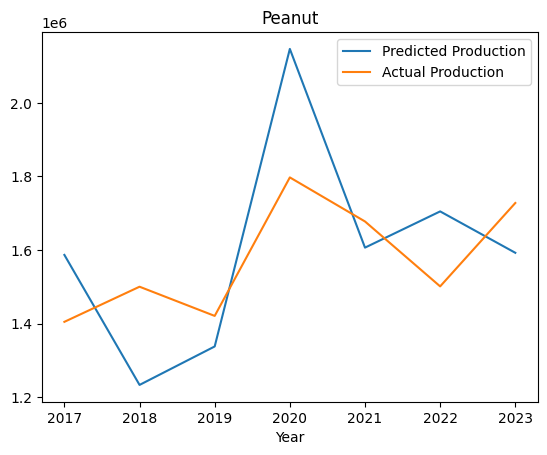

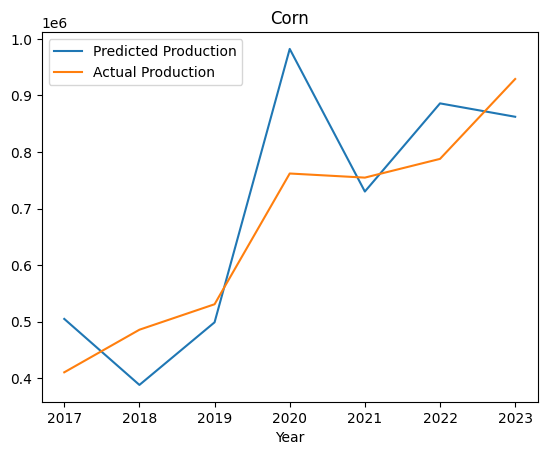

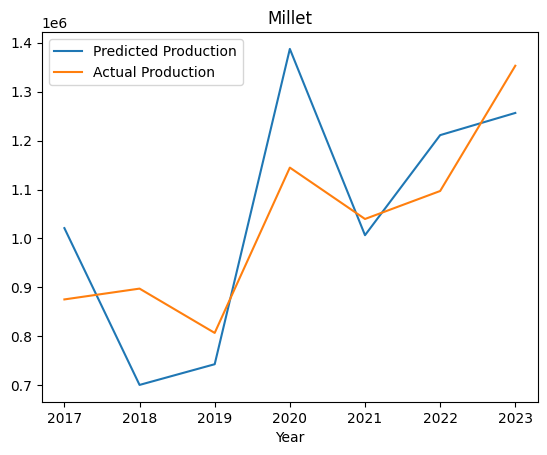

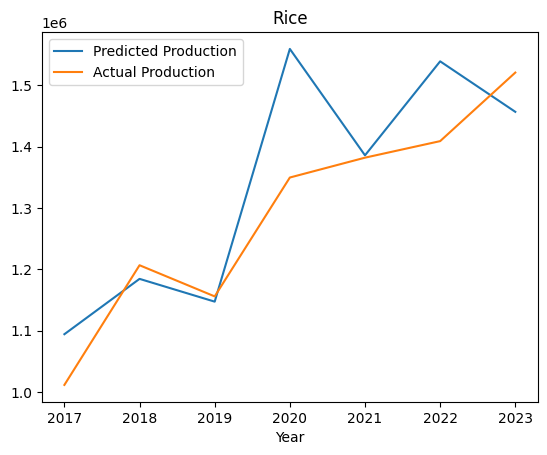

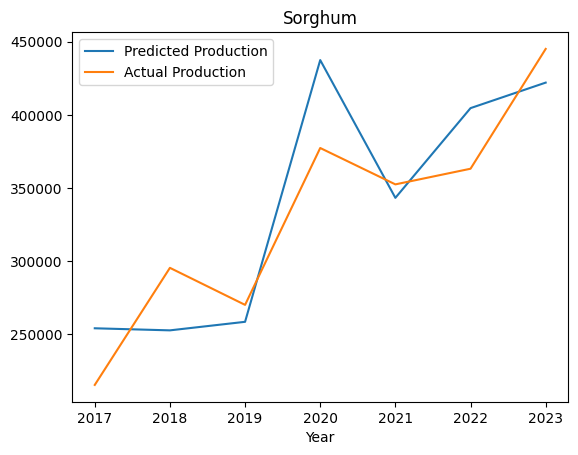

In [29]:
# For each crop, plot predictions and actuals over time (starting in 1996)
# Show actual since 1996, and predicted from 2017 to 2022
for crop in items:
    df = results_df[results_df['Crop'] == crop]
    df = df.set_index('Year')
    df = df[['Predicted Production', 'Actual Production']]
    df.plot()
    plt.title(crop)
    plt.show()

In [30]:
# Next steps
# Clean it up a bit more to make it easier to bring in other features into the model
# Show a bit more of the ARIMA process - maybe in Excel form and explain why we did differencing instead of MA
# Add a few more visualizations to the data (one plot for each crop showing production over time), correlations across features and production / differencing
# Add a few more features to the model (maybe rainfall data, temperature data, etc.)
# Try a few more models (maybe a random forest, ridge regression, lasso regression, etc.)
# Set up a process to test across months (not just from August for FY prediction), and summarize in a table
# Add better commentary to the code and decide where Jeremie and Fatou fit in
# Add a process to document model performance based on changing parameters, additional features, etc.
# Have Fattou or Jeremie set up a Github repository
# Update the chart to be longer term (for reviewing actuals vs. predicted)
# Calculate a range for predictions (e.g. 95% confidence interval) based on performance of the model

# Things to log in logging data (make it easy to adjust these)
# Accuracy in 2022 and 2023
# MAPE by crop
# Total MAPE across crops and years
# Features used in the model
# Model used
# Hyperparameters used